In [35]:
def setup(ax):
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00,length=5)
    ax.tick_params(which='minor', direction='in',width=2.00,length=5)
    ax.patch.set_alpha(0.0)

In [36]:
import jax
jax.config.update("jax_enable_x64", False)


In [37]:
import jax
print("JAX version:", jax.__version__)
print("Devices:", jax.devices())


JAX version: 0.7.0
Devices: [CpuDevice(id=0)]


In [38]:
import os

# Force JAX to use CPU **before** importing jax.numpy or any JAX code
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
print("JAX version:", jax.__version__)
print("Devices:", jax.devices())

JAX version: 0.7.0
Devices: [CpuDevice(id=0)]


In [39]:
def setup(ax):
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    #ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    #ax.yaxis.set_major_locator(ticker.NullLocator())
    #ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='major', direction='in',width=3.00,length=7,labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00,length=5)
    ax.tick_params(which='minor', direction='in',width=2.00,length=5)
    ax.patch.set_alpha(0.0)

In [40]:
import numpy as np
from datetime import datetime
from jax import config
# config.update("jax_traceback_filtering", "off")
from jax import block_until_ready
from jaxincell import simulation, load_parameters, diagnostics

input_parameters, solver_parameters = load_parameters('./examples/bump-on-tail.toml')

# Run the simulation
started = datetime.now()
output = block_until_ready(simulation(input_parameters, **solver_parameters))
print("Simulation done, elapsed:", datetime.now()-started)

# Post-process: segregate ions/electrons, compute energies, compute FFT
diagnostics(output)


Length of the simulation box: inf Debye lengths or 5.130000591278076 Skin Depths
Density of electrons: 743178525212672.0 m^-3
Electron temperature: 1277.497314453125 eV
Ion temperature / Electron temperature: 9.999999717180685e-10
Debye length: 0.0 m
Skin depth: 0.194931760430336 m
Wavenumber * Debye length: 0.0
Pseudoparticles per cell: 1500.0
Pseudoparticle weight: 12386309120.0
Steps at each plasma frequency: 7.797269821166992
Total time: 128.25001525878906 / plasma frequency
Number of particles on a Debye cube: 0.0
Relativistic gamma factor: Maximum 1.1172178983688354, Average 1.008941650390625
Charge x External electric field x Debye Length / Temperature: 0.0



Running for 1,000 iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done, elapsed: 0:00:48.586903


In [44]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

__all__ = ['plot_combined']

def setup(ax):
    """
    Applies custom styling to the matplotlib axis, including larger 
    scientific notation multipliers.
    """
    ax.tick_params(direction='in', length=10, width=4, colors='black')
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major', direction='in', width=3.00, length=7, labelsize=24)
    ax.tick_params(which='minor', direction='in', width=2.00, length=5)
    ax.patch.set_alpha(0.0)
    
    # NEW: Make the "1e8" (scientific notation offset) bigger
    ax.xaxis.get_offset_text().set_fontsize(24)
    ax.yaxis.get_offset_text().set_fontsize(24)

lambda_D = 0.009746588693957116
v_th     = 0.05 * 2.99792458e8


# ---------------------------------------------------
# Combined plotting function
# ---------------------------------------------------
def plot_combined(output, frame=-1, direction="x"):
    fig, axes = plt.subplots(1, 2, figsize=(21, 8))
    ax_energy = axes[0]
    ax_phase = axes[1]


    # ------------------------------------------------------------------
    # -------- LEFT PANEL: PHASE SPACE PLOT (your plot() code) ---------
    # ------------------------------------------------------------------

    grid = output["grid"]
    time_array = output["time_array"] * output["plasma_frequency"]

    if frame < 0:
        frame = len(time_array) + frame

    xmin, xmax = float(grid[0])/lambda_D, float(grid[-1])/lambda_D

    if len(direction) == 1 and direction in "xyz":
        direction_index1 = {"x": 0, "y": 1, "z": 2}[direction]
    else:
        direction_index1 = 0

    species_list = output.get("species", [])
    if not species_list:
        species_list = [
            {"name": "Electrons",
             "positions": output.get("position_electrons"),
             "velocities": output.get("velocity_electrons"),
             "charge": -1.0}
        ]

    electron_species = []
    for i, sp in enumerate(species_list):
        name = sp.get("name", f"Species_{i}")
        charge = sp.get("charge", None)
        is_electron = ("electron" in name.lower()) or (charge is not None and charge < 0)
        
        if is_electron:
            try:
                P = sp["positions"][frame, :, direction_index1] / lambda_D
                V = sp["velocities"][frame, :, direction_index1] / v_th
                
                electron_species.append({"name": name, "P": P, "V": V})
            except:
                continue

    if not electron_species:
        print("No electron species found.")
        return

    all_velocities = [sp["V"] for sp in electron_species]
    global_max_v = max([float(jnp.max(jnp.abs(v))) for v in all_velocities] + [1.0])

    bins_x = len(grid)
    bins_v = max(min(len(grid), 111), 71)

    total_hist = jnp.zeros((bins_x, bins_v))

    xmin, xmax = float(grid[0])/lambda_D, float(grid[-1])/lambda_D
    for sp in electron_species:
        hist, _, _ = jnp.histogram2d(
            sp["P"], sp["V"],
            bins=[bins_x, bins_v],
            range=[[xmin, xmax], [-global_max_v, global_max_v]]
        )
        total_hist += hist

    im = ax_phase.imshow(
        total_hist.T,
        aspect="auto", origin="lower", cmap="twilight",
        extent=[xmin, xmax, -global_max_v, global_max_v],
        vmin=0, vmax=jnp.max(total_hist),
    )
    # Colorbar
    cbar = fig.colorbar(im, ax=ax_phase)
    cbar.ax.tick_params(labelsize=20, width=2, length=5)
    
    # Make colorbar offset text bigger too (if scientific notation appears there)
    cbar.ax.yaxis.get_offset_text().set_fontsize(20)
    
    cbar.set_label("Number of pseudo-particles", fontsize=24)
    cbar.outline.set_linewidth(3)
    ax_phase.set_xlabel(r"Position x ($\lambda_D$)", fontsize=24)
    ax_phase.set_ylabel(r"Velocity x ($v_{\text{th}}$)", fontsize=24)

    setup(ax_phase)


    # ------------------------------------------------------------------
    # -------- RIGHT PANEL: ENERGY PLOT (your second code) -------------
    # ------------------------------------------------------------------

    E = output["electric_field_energy"]
    Energy = output["total_energy"]
    time = jnp.arange(len(E))

    E0 = Energy[0]
    rel_energy = jnp.abs(Energy - E0)/E0

    time_o = time / 7.797270955017352

    ax_energy.semilogy(time_o, E, label="Electric field energy", lw=3)
    ax_energy.plot(time_o, rel_energy, lw=3, label="Relative energy error")
    ax_energy.plot(time_o, Energy, lw=3, label="Relative energy error")
    ax_energy.set_xlabel("Time ($\\omega_{pe}^{-1}$)", fontsize=24)
    ax_energy.set_ylabel("Energy (a.u.)", fontsize=24)
    ax_energy.legend(fontsize=20)

    setup(ax_energy)

    fig.tight_layout()
    plt.show()

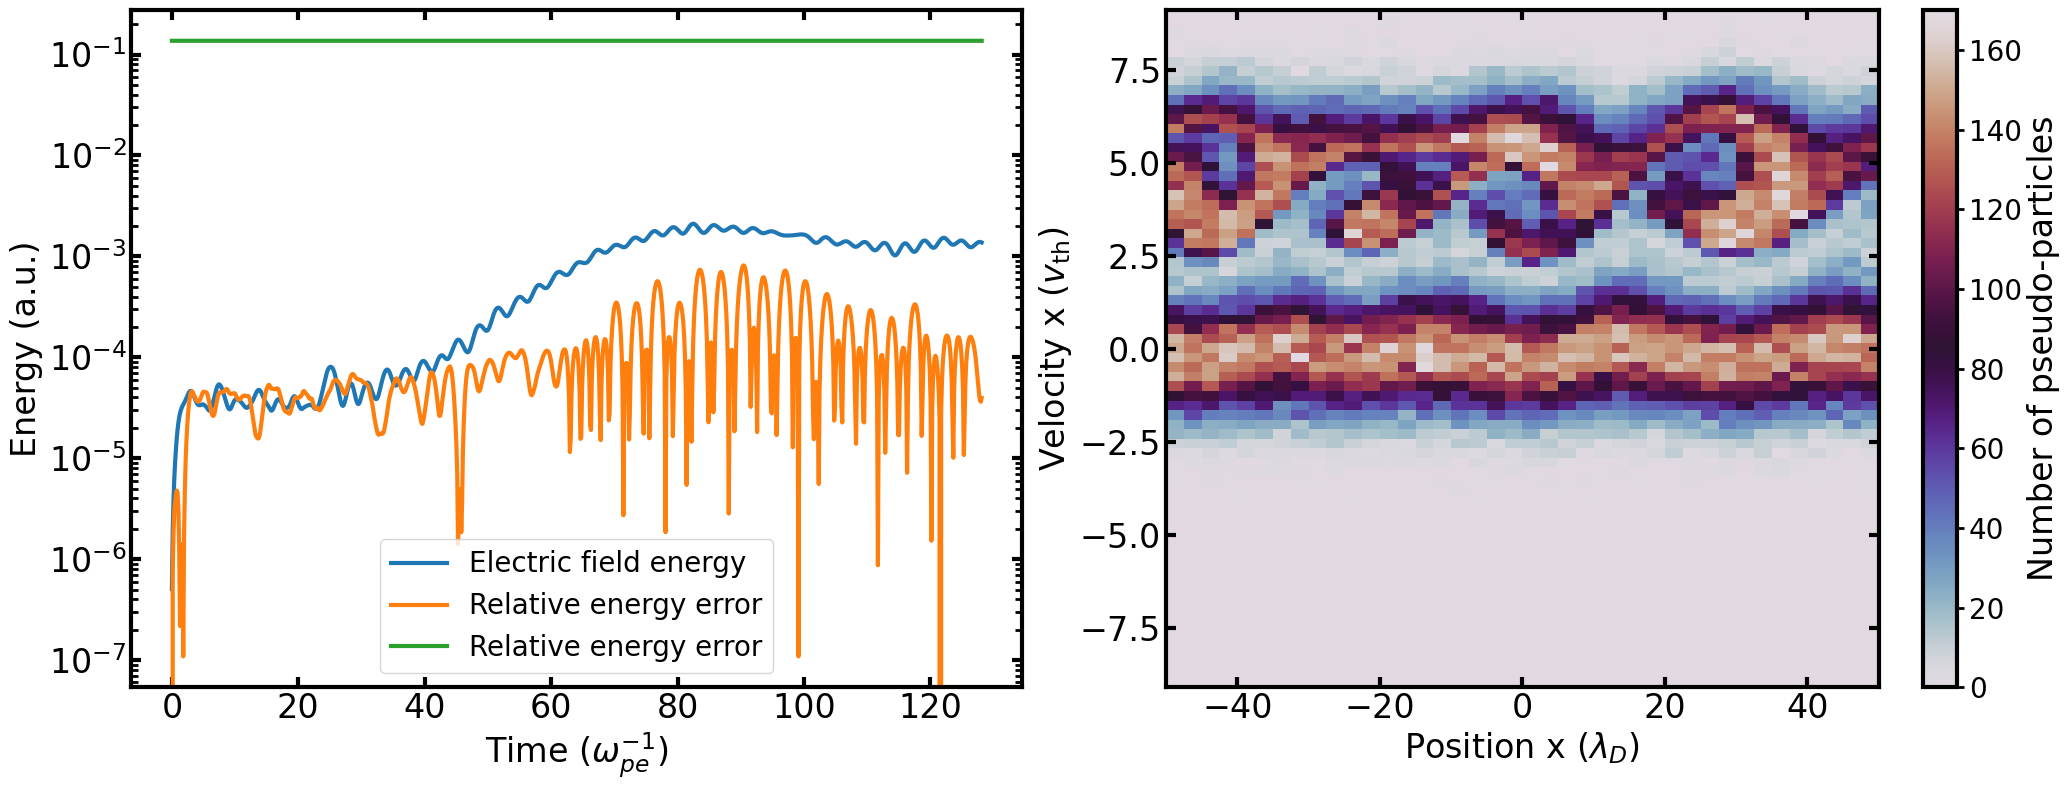

In [43]:
plot_combined(output,545)
